<a href="https://colab.research.google.com/github/fryall/fofo/blob/main/nour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm # import was correct
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten

<ipython-input-5-182a6cc7b209>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm # import was correct


In [7]:
!pip install split-folders

In [8]:
import splitfolders
image_size=[244,244]
input_folder = '/content/drive/MyDrive/try1'
splitfolders.ratio(input_folder, output="koko",
                   seed=42, ratio=(.7, .3 ),
                   group_prefix=None)

Copying files: 570 files [00:12, 45.05 files/s] 


In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data = ImageDataGenerator(rescale=1./255,  # Normalize pixel values
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_data = ImageDataGenerator(rescale=1./255)  # Only normalize for test data

train_path = train_data.flow_from_directory(
    "/content/koko/train",
    target_size=(224, 224),  # Resize images to match model input
    batch_size=32,
    class_mode='categorical')  # Assuming categorical classification

test_path = test_data.flow_from_directory(
    "/content/koko/val",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 398 images belonging to 2 classes.
Found 172 images belonging to 2 classes.


In [9]:
from keras.applications import vgg16


img_rows, img_cols = 224, 224


vgg = vgg16.VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (img_rows, img_cols, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
for layer in vgg.layers:
    layer.trainable = False

In [11]:
 def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be
    placed ontop of the bottom layers"""
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model


num_classes = 2

FC_Head = lw(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = FC_Head)

print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │         525,3

 Total params: 16,815,426 (64.15 MB)

 Trainable params: 2,100,738 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [19]:
from tensorflow.keras.models import Model
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [27]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("vgg16_1.keras", monitor="val_accuracy", verbose=1, save_best_only=True, save_weights_only=False)
early_stopping = EarlyStopping(monitor="val_accuracy", min_delta=0, patience=40, verbose=1, mode='auto')

# Assuming 'train_path' and 'test_path' are directories containing images


# Use model.fit with generators and specify steps_per_epoch
history = model.fit(x=train_path, steps_per_epoch=2, epochs=5,
                 validation_data=test_path, validation_steps=1,
                 callbacks=[checkpoint])


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.9141 - loss: 0.3569
Epoch 1: val_accuracy improved from -inf to 0.96875, saving model to vgg16_1.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - accuracy: 0.9167 - loss: 0.3550 - val_accuracy: 0.9688 - val_loss: 0.2877
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8168 - loss: 0.3448
Epoch 2: val_accuracy did not improve from 0.96875
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step - accuracy: 0.8271 - loss: 0.3262 - val_accuracy: 0.8438 - val_loss: 0.2403
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9297 - loss: 0.1794   
Epoch 3: val_accuracy did not improve from 0.96875
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.9271 - loss: 0.1831 - val_accuracy: 0.9062 - val_loss: 0.2079
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9609 - loss: 0.1524
Epoch 4: val_accuracy did not improve from 0.96875
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.9583 - loss: 0.1584 - val_accuracy: 0.9062 - val_

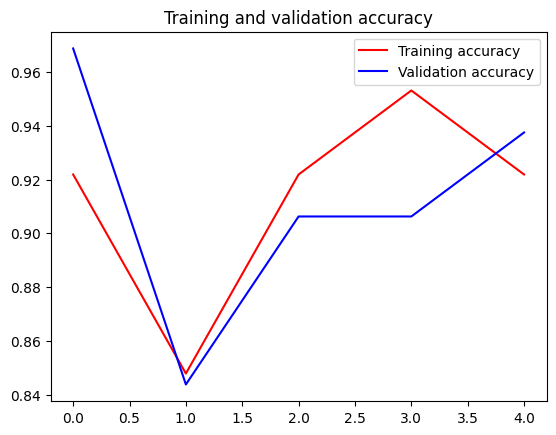

<Figure size 640x480 with 0 Axes>

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step


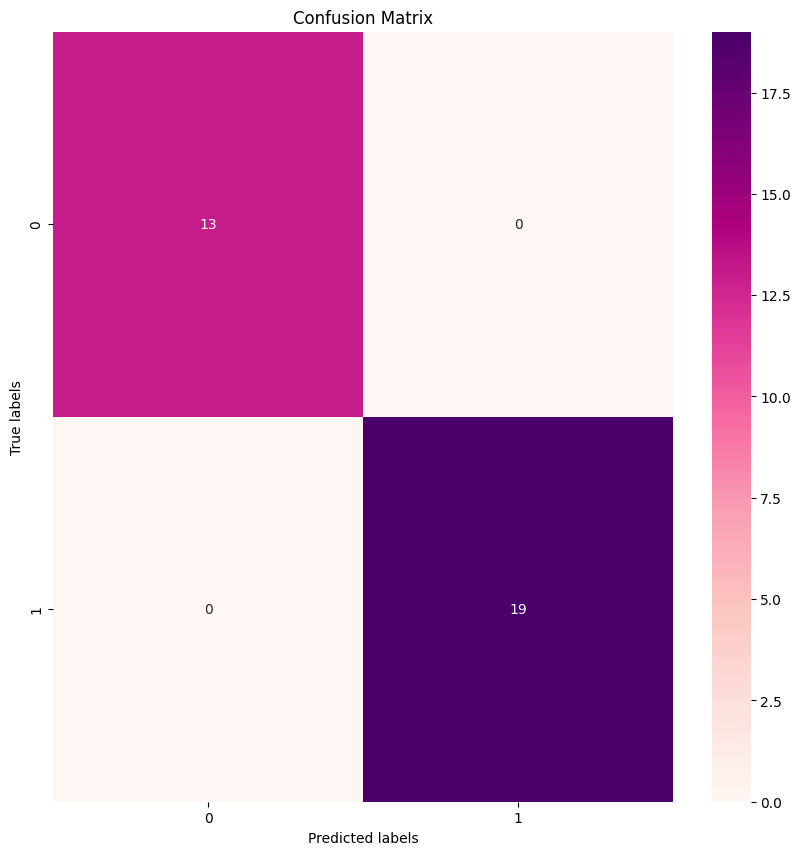

Validation Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'test_path' is defined as in your previous code
X_test, y_test = next(test_path)  # Extract data and labels from the generator

# Predict labels for validation set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='RdPu')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


# Calculate precision, recall, F1 score, and accuracy
report = classification_report(y_true_classes, y_pred_classes, output_dict=True)
accuracy = report['accuracy']
precision = report['macro avg']['precision']
recall = report['macro avg']['recall']
f1_score = report['macro avg']['f1-score']

# Display the calculated metrics
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1_score:.4f}')